# Temporal Autoencoder

This example implements a variational autoencoder that predicts the future time-course of a signal.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils

import numpy as np

import tensorflow as tf

import dlop_ldn_function_bases as bases

from temporal_basis_transformation_network import Forward, Inverse
from temporal_basis_transformation_network.keras import TemporalBasisTrafo

import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [3]:
dt, T = 1e-3, 1000.0
N_ts = int(T / dt)

# Generate a long test signal corresponding to a sine wave oscillating at
# different frequencies over time
env = utils.FrequencyModulatedSine(f0=1.0, f1=5.0, dt=dt)
ts = np.linspace(0, T - dt, N_ts)
_, xs, us = env.step(N_ts)

In [4]:
# Chop up the data into a bunch of training samples
N = 512 # Length of one sample
N_smpls = 20000 # Number of samples to generate
smpls_x, smpls_t = np.zeros((2, N_smpls, N, 1))
smpls_u = np.zeros((N_smpls,))
for i in range(N_smpls):
    i0 = np.random.randint(N_ts - 2 * N)
    i1 = i0 + N
    i2 = i0 + 2 * N
    smpls_x[i] = xs[i0:i1] # Input
    smpls_t[i] = xs[i1:i2] # Target prediction
    smpls_u[i] = np.mean(us[i0:i2])

smpls_train_x = smpls_x[N_smpls // 2:]
smpls_train_t = smpls_t[N_smpls // 2:]
smpls_train_u = smpls_u[N_smpls // 2:]

smpls_test_x = smpls_x[:N_smpls // 2]
smpls_test_t = smpls_t[:N_smpls // 2]
smpls_test_u = smpls_u[:N_smpls // 2]

In [48]:
class TAE(tf.keras.Model):
    def __init__(self, H, n_neurons=100, n_latent_dims=3, λ=1e-4, σ=1e-1):
        super().__init__()

        # Construct the individual networks
        q, N = H.shape

        # Short-hand for the L2 regularizer
        L2 = lambda λ: tf.keras.regularizers.l2(λ)

        # Collect all layers and call the super-constructor
        self.encoder = tf.keras.Sequential((
            # Take the input over time and perform a basis transformation
            TemporalBasisTrafo(H, n_units=1, pad=False),

            # Encode the q-dimensional output using n_neurons
            tf.keras.layers.Dense(n_neurons,
                                  activation=tf.nn.relu,
                                  kernel_regularizer=L2(λ)),

            # Decode the latent dimensions. The weights connecting to this
            # layer must be L2-regularized to prevent overfitting.
            tf.keras.layers.Dense(n_latent_dims,
                                  activation=None,
                                  use_bias=False,
                                  kernel_regularizer=L2(λ)),

            # Make sure that the latent dimensions are normalized to have
            # a zero mean and a 
            tf.keras.layers.BatchNormalization(),

            # Before decoding, add some Gaussian noise to the latent state to
            # prevent more overfitting.
            tf.keras.layers.GaussianNoise(σ),
        ), name="encoder")

        self.decoder = tf.keras.Sequential((
            # Map the latent state onto a number of neurons
            tf.keras.layers.Dense(n_neurons,
                                  activation=tf.nn.relu,
                                  kernel_regularizer=L2(λ)),

            # Decode the q-dimensional basis transformation
            tf.keras.layers.Dense(q,
                                  activation=None,
                                  use_bias=False,
                                  kernel_regularizer=L2(λ)),

            # Transform the input back to sampled space
            TemporalBasisTrafo(H, n_units=1, mode=Inverse),
        ), name="decoder")
        
        # Set some local variables
        self.q, self.N = q, N

    def encode(self, xs):
        return self.encoder(xs)

    def decode(self, xs):
        return sefl.decoder(xs)

    def call(self, xs, *args, **kwargs):
        return self.decoder(self.encoder(xs, *args, **kwargs), *args, **kwargs)

In [49]:
H = bases.mk_fourier_basis(7, N)
tae = TAE(H)

In [50]:
tae.build(input_shape=(None, 512, 1))
tae.summary()

Model: "tae_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 1, 3)              1112      
_________________________________________________________________
decoder (Sequential)         (None, 1, 512)            1100      
Total params: 2,212
Trainable params: 2,206
Non-trainable params: 6
_________________________________________________________________


In [51]:
tae.compile(optimizer='adam',
            loss=tf.keras.losses.mse,
            metrics=['mse'])

In [52]:
tae.fit(smpls_train_x, smpls_train_t.reshape(-1, 1, N), epochs=30)

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 0.4657 - mse: 0.4615
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 0.3175 - mse: 0.3098
Epoch 3/30
313/313 [==============================] - 0s 2ms/step - loss: 0.2581 - mse: 0.2478
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2251 - mse: 0.2139
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2139 - mse: 0.2022
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2046 - mse: 0.1925
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1920 - mse: 0.1796
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1862 - mse: 0.1738
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1894 - mse: 0.1769
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1810 - mse: 0.1684
Epoch 11/30
313/313 [============================

In [53]:
tae.evaluate(smpls_test_x, smpls_test_t.reshape(-1, 1, N))

313/313 [==============================] - 0s 769us/step - loss: 0.1179 - mse: 0.1042


[0.11786559969186783, 0.10417623072862625]

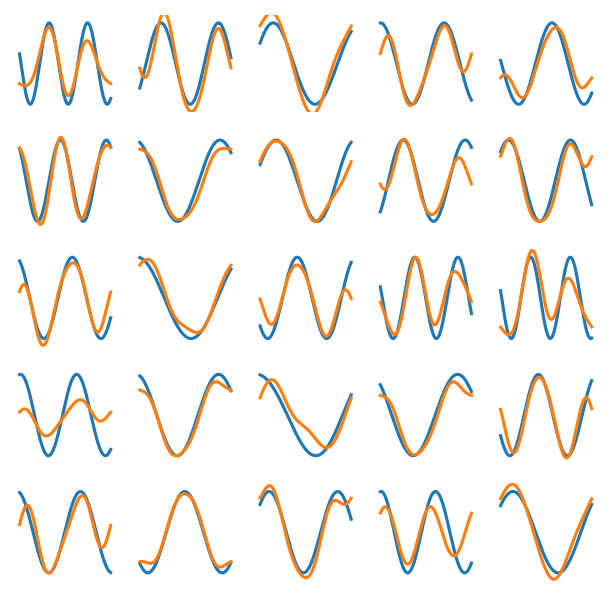

In [54]:
rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(5.0, 5.0))
for i, ax in enumerate(axs.flat):
    ax.plot(smpls_test_t[i])
    ax.plot(tae(smpls_test_x[i]).numpy().flatten())
    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-1.2, 1.2)